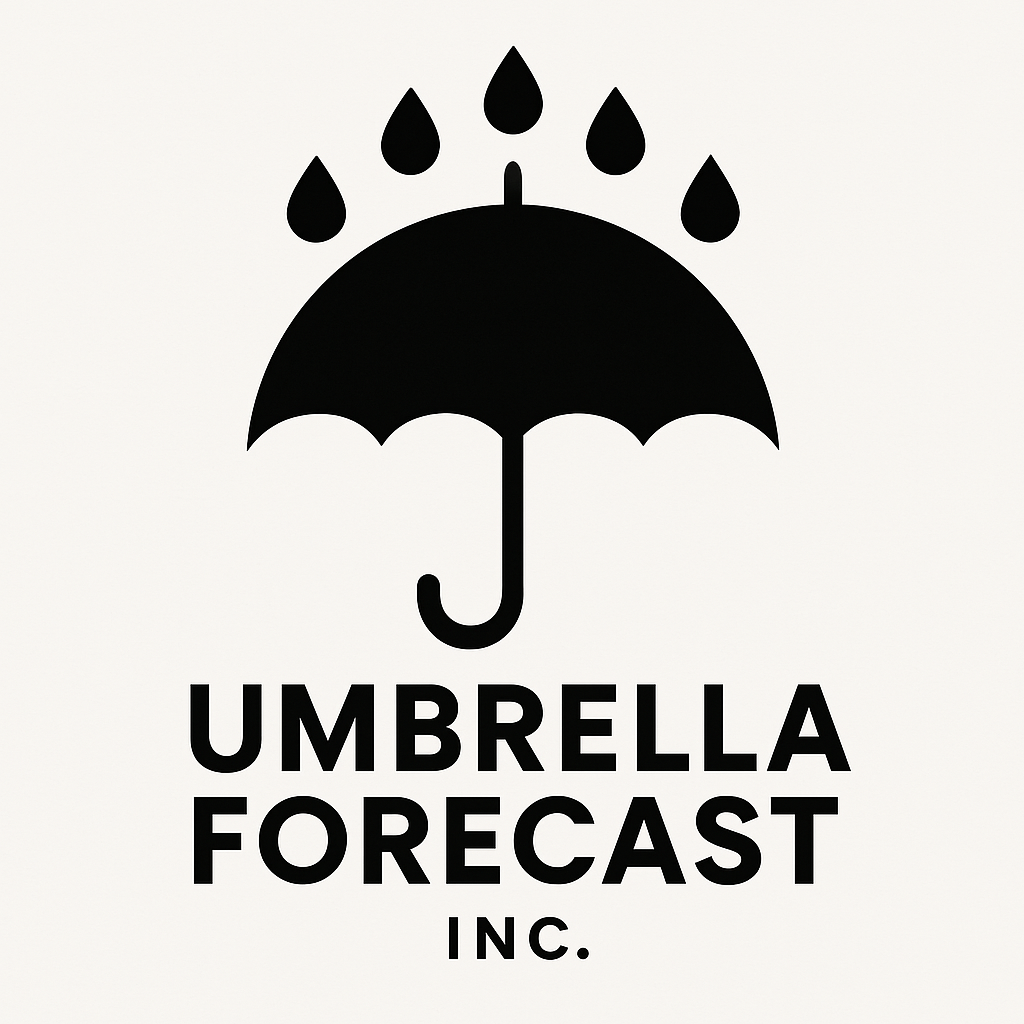

Otimização de Estoque
Evita excesso de estoque em dias secos e faltas em dias chuvosos.

Permite alocar guarda-chuvas nas lojas ou pontos de venda certos no momento certo.

Reduz custos com armazenagem e perdas por encalhe.

Exemplo: Se o modelo prevê alto volume de chuva na próxima semana, a empresa pode enviar mais guarda-chuvas para as lojas antes da demanda subir.

In [1]:
!pip install -q scikit-learn pandas matplotlib seaborn

# 🧪 Importando bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
# 🔮 Gerando dataset fictício
np.random.seed(42)
n = 365  # um ano de dados diários

data = pd.DataFrame({
    'dia': pd.date_range(start='2024-01-01', periods=n, freq='D'),
    'chuva_mm': np.random.gamma(shape=2, scale=5, size=n),  # chuva entre 0-50mm
    'temperatura_C': np.random.normal(loc=22, scale=5, size=n),
    'umidade_%': np.random.normal(loc=70, scale=10, size=n),
})

# 💡 Regra simples: mais chuva -> mais guarda-chuvas vendidos
data['vendas_guarda_chuva'] = (
    5 + data['chuva_mm'] * 2
    - data['temperatura_C'] * 0.3
    + data['umidade_%'] * 0.1
    + np.random.normal(0, 5, size=n)
).astype(int)

data['vendas_guarda_chuva'] = data['vendas_guarda_chuva'].clip(lower=0)
data.head()


,dia,chuva_mm,temperatura_C,umidade_%,vendas_guarda_chuva
0,2024-01-01,11.968397,19.865595,88.119801,29
1,2024-01-02,7.472324,26.261232,73.579257,15
2,2024-01-03,6.911418,10.396313,73.932632,11
3,2024-01-04,6.911511,20.850602,76.814451,21
4,2024-01-05,23.248572,25.140700,64.205367,51


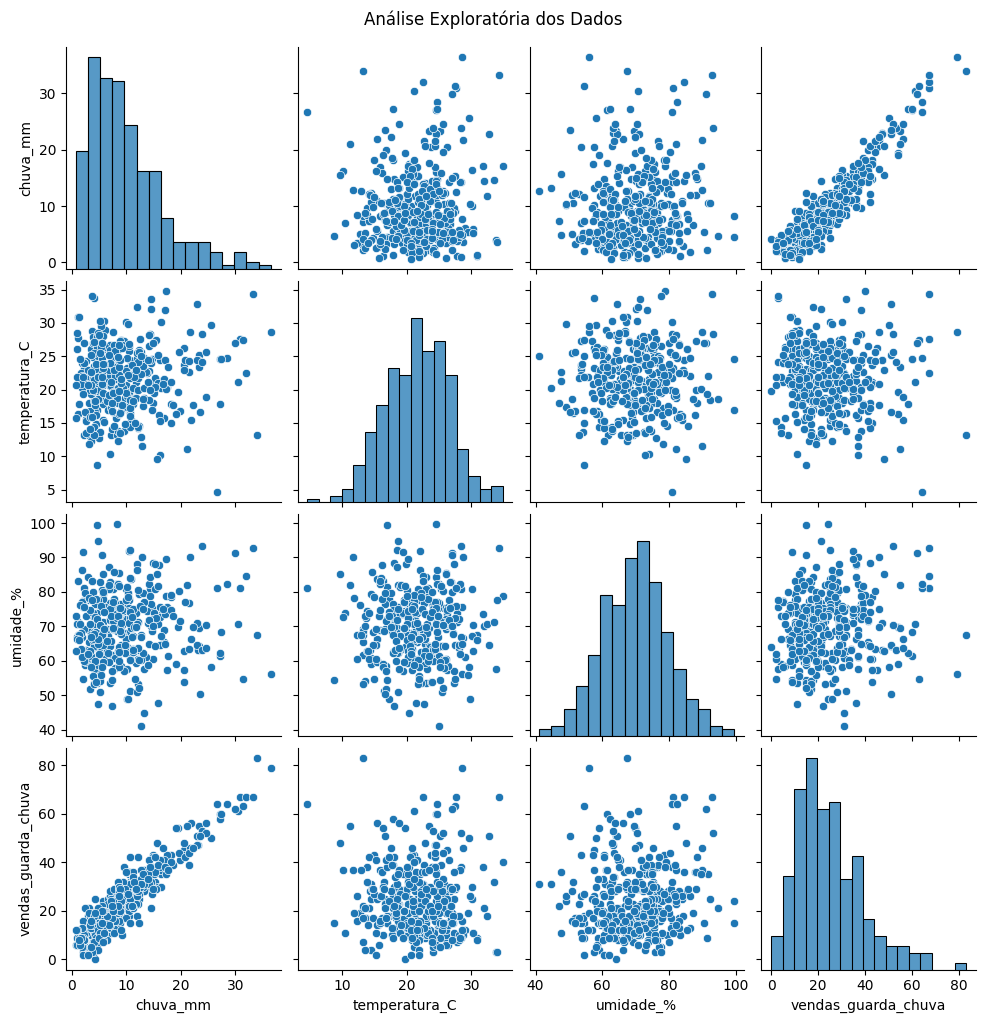

In [3]:
sns.pairplot(data[['chuva_mm', 'temperatura_C', 'umidade_%', 'vendas_guarda_chuva']])
plt.suptitle("Análise Exploratória dos Dados", y=1.02)
plt.show()


In [4]:
# 🎯 Features e target
X = data[['chuva_mm', 'temperatura_C', 'umidade_%']]
y = data['vendas_guarda_chuva']

# 🔀 Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 📘 Modelo de Regressão Linear
modelo = LinearRegression()
modelo.fit(X_train, y_train)

# 🔍 Predições
y_pred = modelo.predict(X_test)


MSE: 18.19644589958915
R²: 0.9241384126858536


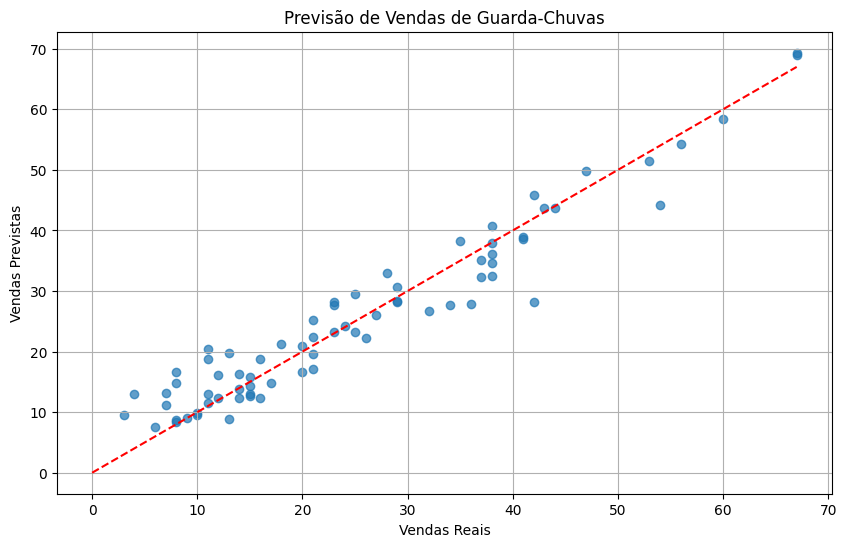

In [5]:
print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

# 🔍 Comparar predições
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--')
plt.xlabel("Vendas Reais")
plt.ylabel("Vendas Previstas")
plt.title("Previsão de Vendas de Guarda-Chuvas")
plt.grid(True)
plt.show()


# AZURE SDK

In [ ]:
!pip install azure-ai-ml mlflow pandas scikit-learn

In [ ]:
import os
import mlflow
import pandas as pd
import numpy as np
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential
from azure.ai.ml.entities import Environment, AmlCompute, Model
from azure.ai.ml.constants import AssetTypes
from azure.ai.ml import command
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Configurações do Azure ML
subscription_id = "SEU_SUBSCRIPTION_ID"
resource_group = "SEU_RESOURCE_GROUP"
workspace_name = "SEU_WORKSPACE_NAME"

# Autenticação e criação do cliente do Azure ML
credential = DefaultAzureCredential()
ml_client = MLClient(credential, subscription_id, resource_group, workspace_name)

# Configuração do MLflow para usar o Azure ML como backend
mlflow.set_tracking_uri(ml_client.workspaces.get(workspace_name).mlflow_tracking_uri)

# Nome do experimento no MLflow
experiment_name = "previsao_vendas_guardachuvas"
mlflow.set_experiment(experiment_name)

# Geração de dados fictícios
np.random.seed(42)
n = 365  # um ano de dados diários

data = pd.DataFrame({
    'dia': pd.date_range(start='2024-01-01', periods=n, freq='D'),
    'chuva_mm': np.random.gamma(shape=2, scale=5, size=n),
    'temperatura_C': np.random.normal(loc=22, scale=5, size=n),
    'umidade_%': np.random.normal(loc=70, scale=10, size=n),
})

data['vendas_guarda_chuva'] = (
    5 + data['chuva_mm'] * 2
    - data['temperatura_C'] * 0.3
    + data['umidade_%'] * 0.1
    + np.random.normal(0, 5, size=n)
).astype(int)

data['vendas_guarda_chuva'] = data['vendas_guarda_chuva'].clip(lower=0)

# Salvando os dados em um arquivo CSV temporário
data_path = "dados_vendas_guardachuvas.csv"
data.to_csv(data_path, index=False)

# Definição do cluster de computação
compute_name = "cpu-cluster"
if compute_name not in [c.name for c in ml_client.compute.list()]:
    compute_cluster = AmlCompute(
        name=compute_name,
        size="STANDARD_DS11_V2",
        min_instances=0,
        max_instances=4
    )
    ml_client.compute.begin_create_or_update(compute_cluster).result()

# Definição do ambiente
env_name = "sklearn-env"
env_docker_image = "mcr.microsoft.com/azureml/sklearn-0.24.1-ubuntu18.04-py37-cpu-inference"

env = Environment(
    name=env_name,
    image=env_docker_image,
    conda_file=None
)
ml_client.environments.create_or_update(env)

# Script de treinamento
train_script = """
import mlflow
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Iniciar o MLflow
mlflow.start_run()

# Carregar os dados
data = pd.read_csv('dados_vendas_guardachuvas.csv')

# Definir features e target
X = data[['chuva_mm', 'temperatura_C', 'umidade_%']]
y = data['vendas_guarda_chuva']

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinar o modelo
modelo = LinearRegression()
modelo.fit(X_train, y_train)

# Fazer previsões
y_pred = modelo.predict(X_test)

# Calcular métricas
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Logar métricas no MLflow
mlflow.log_metric("MSE", mse)
mlflow.log_metric("R2", r2)

# Logar o modelo no MLflow
mlflow.sklearn.log_model(modelo, "modelo_guardachuvas")

mlflow.end_run()
"""

# Salvando o script de treinamento em um arquivo
train_script_path = "train_model.py"
with open(train_script_path, "w") as f:
    f.write(train_script)

# Configuração do trabalho de treinamento
job = command(
    code="./",
    command="python train_model.py",
    inputs={"dados": data_path},
    environment=env,
    compute=compute_name,
    experiment_name=experiment_name,
    display_name="treinamento_guardachuvas"
)

# Submissão do trabalho
ml_client.jobs.create_or_update(job)